In [283]:
import numpy as np
import matplotlib.pyplot as plt
import math 
import bisect
from typing import List
import scipy.special as special

"""
Original code from rejection sampling homework
"""

class RNG:
    def __init__(self, seed=None):
        self._rng = np.random.default_rng(seed)
        self.random = self._rng.random
    
    def seed(self, seed=None):
        self._rng = np.random.default_rng(seed)
    
    def uniform(self, low=0.0, high=1.0, size=None):
        return low + (high - low) * self.random(size)
    
    # choose a random object from a list
    def choice(self, list_, size=None):
        u = self.random(size)
        return list_[np.floor(u * len(list_)).astype(int)]
    
    def discrete(self, weights, list_=None, size=None):
        total_weight = sum(weights)
        intervals = np.cumsum(weights) / total_weight
        u_samples = self.random(size)
        return [list_[bisect.bisect_left(intervals, s)] for s in u_samples]
    
    def bernoulli(self, p=0.5, size=None):
        assert 0 <= p <= 1, "p must be between 0 and 1"
        u = self.random(size)
        return (u < p).astype(int)
        
    def binomial(self, n=1, p=0.5, size=None):
        assert 0 <= p <= 1, "p must be between 0 and 1"
        sample = lambda x, y: np.sum(self.bernoulli(x, y))
        return np.array([sample(p, n) for _ in range(size)])
    
    def exponential(self, lambda_=1.0, size=None):
        assert lambda_ > 0, "lambda must be positive"
        return -1/lambda_ * np.log(1 - self.uniform(size=size))
    
    def normal(self, mean=0.0, std=1.0, size=None):
        R = np.sqrt(-2 * np.log(1 - self.uniform(size=size)))
        Theta = 2 * np.pi * self.uniform(size=size)
        return mean + std * R * np.cos(Theta)
        
    def poisson(self, lambda_=1.0, size=None):
        assert lambda_ > 0, "lambda must be positive"
        samples = np.zeros(size)
        for i in range(size):
            N, sum = 0, 0
            while True:
                X = self.exponential(lambda_, size=1)
                sum += X
                if sum > 1:
                    break
                N += 1
            samples[i] = N
        return samples

    def beta(self, a=1.0, b=1.0, size=None):
        assert a > 0 and b > 0, "a and b must be positive"
        assert isinstance(a, int) and isinstance(b, int), "a and b must be integers for this specific implementation"
        k, n = a, b + a - 1
        samples = np.array([self.uniform(size=n) for _ in range(size)])
        samples.sort(axis=1)
        return np.array([row[k-1] for row in samples])


    def triangular(self, low=0.0, high=1.0, mode=None, size=None):
        assert low <= mode <= high, "low <= mode <= high"
        samples = self.uniform(size=size)
        samples.sort()
        crit = (mode - low) / (high - low)
        return np.where(
            samples < crit, 
            low + np.sqrt(samples * (high - low) * (mode - low)), 
            high - np.sqrt((1 - samples) * (high - low) * (high - mode))
            )

    def weibull(self, shape=1.0, scale=1.0, size=None):
        assert shape > 0, "shape must be positive"
        assert scale > 0, "scale must be positive"
        return scale * (-np.log(1 - self.uniform(size=size)))**(1/shape)

class RandomVariable():
    def __init__(self, rng):
        self.rng = rng
        
    def pdf(self, x):
        raise NotImplementedError
    
    def rsv(self, size=None):
        raise NotImplementedError

class Uniform(RandomVariable):
    def __init__(self, rng, low=0.0, high=1.0):
        super().__init__(rng)
        self.low = low
        self.high = high
        
    def rsv(self, size=None):
        return np.array(self.rng.uniform(low=self.low, high=self.high, size=size))

    def pdf(self, x):
        return np.array(np.where((x >= self.low) & (x <= self.high), 1 / (self.high - self.low), 0))

class Discrete(RandomVariable):
    def __init__(self, rng, weights, list_=None):
        super().__init__(rng)
        self.weights = weights
        self.list_ = list_
        
    def rsv(self, size=None):
        return np.array(self.rng.discrete(weights=self.weights, list_=self.list_, size=size))

    def pdf(self, x):
        return np.array(self.weights[self.list_.index(x)])

class Mixture(RandomVariable):
    def __init__(self, rng, weights, components: List[RandomVariable]):
        assert len(weights) == len(components), "weights and components must have the same length"
        super().__init__(rng)
        self.weights = weights
        self.components = components
    
    def rsv(self, size=None):
        sampled_components = Discrete(self.rng, self.weights, self.components).rsv(size=size)
        return np.array([comp.rsv() for comp in sampled_components])

    def pdf(self, x):
        return np.array(sum([w * c.pdf(x) for w, c in zip(self.weights, self.components)]))

class Normal(RandomVariable):
    def __init__(self, rng, mean=0.0, std=1.0):
        super().__init__(rng)
        self.mean = mean
        self.std = std
        
    def rsv(self, size=None):
        return np.array(self.rng.normal(mean=self.mean, std=self.std, size=size))

    def pdf(self, x):
        return np.array(np.exp(-0.5 * ((x - self.mean) / self.std)**2) / np.sqrt(2 * np.pi * self.std**2))

def rejection_rsv(target_pdf, proposal_rv: RandomVariable, majorizing_constant, size, rng=None):
    if rng is None:
        rng = RNG()
    accept = []
    trials = 0
    U = Uniform(rng, 0, 1)
    while len(accept) < size:
        x = proposal_rv.rsv(1)
        u = U.rsv(None)
        if u <= target_pdf(x) / (majorizing_constant * proposal_rv.pdf(x)):
            accept.append(x)
        trials += 1
    efficiency = size / trials
    return np.array(accept), efficiency

In [284]:
import numpy as np
import bisect

"""
Code for the final project, adaptive rejection sampling
"""

class ARNG:
    def __init__(self, seed=None):
        self._rng = np.random.default_rng(seed)
    def uniform(self, low=0.0, high=1.0, size=None):
        return self._rng.random(size) * (high - low) + low
    def choice(self, a, p=None):
        return self._rng.choice(a, p=p)

def adaptive_rejection_sampling(
    log_pdf,
    dlog_pdf,
    Dl,
    Du,
    initial_x,
    n_samples,
    rng=None
):
    """
    Adaptive Rejection Sampling for a log-concave target.

    Parameters
    ----------
    log_pdf : callable
        Function returning log(f(x)).
    dlog_pdf : callable
        Function returning derivative of log(f(x)).
    Dl, Du : float
        Left and right domain endpoints (use -np.inf/np.inf if unbounded).
    initial_x : list of float
        Initial abscissae (must lie in [Dl,Du], sorted or unsorted).
    n_samples : int
        Number of samples to draw.
    rng : RNG, optional
        A random‑number generator with .uniform and .choice methods.

    Returns
    -------
    samples : np.ndarray
        Array of shape (n_samples,) of draws from f.
    efficiency : float
        Acceptance fraction (n_samples / total proposals).
    """
    if rng is None:
        rng = ARNG()

    # sort abscissae
    Tk = sorted(initial_x)
    samples = []
    trials = 0
    cached_vals = {}
    cached_dvals = {}
    num_calculations = [0]
    calculations_array = [0]

    def calculate_trueval(x):
        cached_vals[x] = log_pdf(x)
        cached_dvals[x] = dlog_pdf(x)
        num_calculations[0] += 1
        return cached_vals[x]

    def construct_hull(abscissae):
        """Build tangent slopes/intercepts, intersection points, and piece‑areas."""
        m = []  # slopes of tangents
        b = []  # intercepts of tangents
        for x in abscissae:
            slope = cached_dvals[x]
            intercept = cached_vals[x] - slope * x
            m.append(slope)
            b.append(intercept)

        # compute intersection points z
        z = [Dl]
        for i in range(len(abscissae) - 1):
            # solve m[i]*z + b[i] = m[i+1]*z + b[i+1]
            zi = (b[i+1] - b[i]) / (m[i] - m[i+1])
            z.append(zi)
        z.append(Du)

        # compute unnormalized piece areas A_i = ∫ exp(m_i x + b_i) dx over [z[i], z[i+1]]
        A = []
        for i in range(len(abscissae)):
            if abs(m[i]) > 1e-16:
                e_low = np.exp(m[i] * z[i])
                e_high = np.exp(m[i] * z[i+1])
                Ai = np.exp(b[i]) * (e_high - e_low) / m[i]
            else:
                Ai = np.exp(b[i]) * (z[i+1] - z[i])
            A.append(Ai)

        Z = sum(A)
        p = np.array(A) / Z  # normalized piece probabilities
        return m, b, z, p
    
    # initialize cached values
    for x in Tk:
        calculate_trueval(x)
    calculations_array.append(num_calculations[0])

    while len(samples) < n_samples:
        # 1. Build hull
        m, b, z, p = construct_hull(Tk)

        # 2. Sample one segment index i ∼ p
        i = rng.choice(len(p), p=p)

        # 3. Sample x* by inverse CDF on [z[i], z[i+1]]
        u = rng.uniform()
        if abs(m[i]) > 1e-16:
            e_low = np.exp(m[i] * z[i])
            e_high = np.exp(m[i] * z[i+1])
            x_star = (1.0 / m[i]) * np.log(u * (e_high - e_low) + e_low)
        else:
            x_star = z[i] + u * (z[i+1] - z[i])

        # 4. Squeeze and rejection tests
        w = rng.uniform()
        # secant (lower hull) on [Tk[i], Tk[i+1]]
        xL, xR = Tk[i], Tk[i+1] if i+1 < len(Tk) else Du

        hL = cached_vals[xL]
        if xR == np.inf:
            slope_sec = 0
        else:
            hR = cached_vals[xR]
            slope_sec = (hR - hL) / (xR - xL)

        intercept_sec = hL - slope_sec * xL

        # value on hat: u_i(x*) = m[i] * x* + b[i]
        hat_val = m[i] * x_star + b[i]
        # value on secant: l_i(x*) = slope_sec * x* + intercept_sec
        sec_val = slope_sec * x_star + intercept_sec

        if w <= np.exp(sec_val - hat_val):
            samples.append(x_star)
            calculations_array.append(num_calculations[0])
        else:
            log_val = cached_vals[x_star] if x_star in cached_vals else calculate_trueval(x_star)
            if w <= np.exp(log_val - hat_val):
                samples.append(x_star)
                calculations_array.append(num_calculations[0])
            else:
                # reject and add x* to abscissae
                bisect.insort(Tk, x_star)

        trials += 1

    samples = np.array(samples)
    efficiency = n_samples / trials
    return samples, efficiency, num_calculations, calculations_array

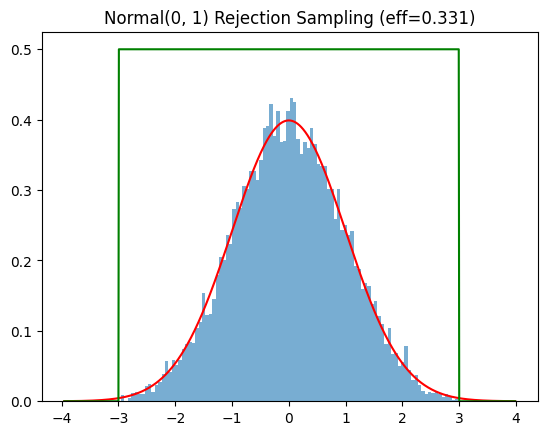

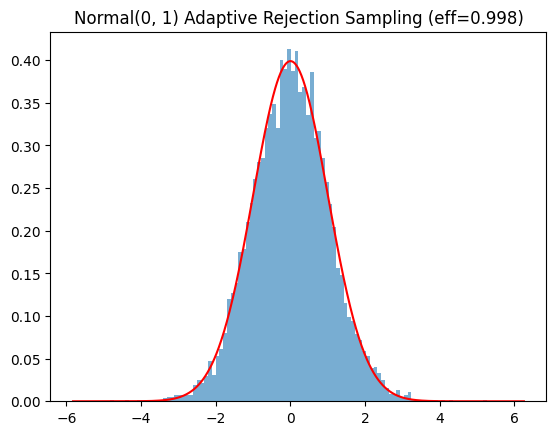

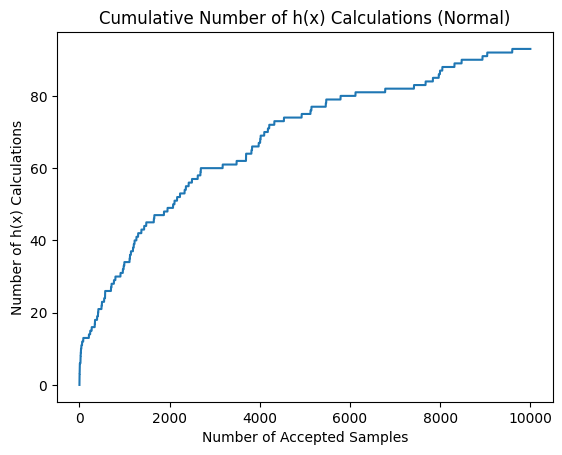

In [285]:
"""
Comparisons between traditional and adaptive rejection sampling using a standard normal target distribution
"""

N = 10000

# ----- Traditional Rejection Sampling -----
rng = RNG()
target_pdf = Normal(rng, mean=0, std=1).pdf
proposal = Uniform(rng, low=-3, high=3)
M = 3

trad_samples, trad_efficiency = rejection_rsv(target_pdf, proposal, M, N)

plt.hist(trad_samples, math.floor(math.sqrt(N)), density=True, alpha=0.6)
plt.title('Normal(0, 1) Rejection Sampling (eff={:.3f})'.format(trad_efficiency))

x = np.linspace(trad_samples.min() - 1, trad_samples.max() + 1, 1000)
plt.plot(x, target_pdf(x), "red")
plt.plot(x, M*proposal.pdf(x), "green")
plt.show()

# ----- Adaptive Rejection Sampling -----
log_pdf = lambda x: -0.5*x*x - 0.5*np.log(2*np.pi)
dlog_pdf = lambda x: -x

adap_samples, adap_efficiency, num_calculations, calculations_array = adaptive_rejection_sampling(
    log_pdf, dlog_pdf,
    Dl=-np.inf, Du=np.inf,
    initial_x=[-2.0, 2.0],
    n_samples=N
)

plt.hist(adap_samples, math.floor(math.sqrt(N)), density=True, alpha=0.6)
plt.title('Normal(0, 1) Adaptive Rejection Sampling (eff={:.3f})'.format(adap_efficiency))

x = np.linspace(adap_samples.min() - 1, adap_samples.max() + 1, 1000)
plt.plot(x, target_pdf(x), "red")
plt.show()

plt.plot(calculations_array)
plt.title("Cumulative Number of h(x) Calculations (Normal)")
plt.xlabel("Number of Accepted Samples")
plt.ylabel("Number of h(x) Calculations")
plt.show()

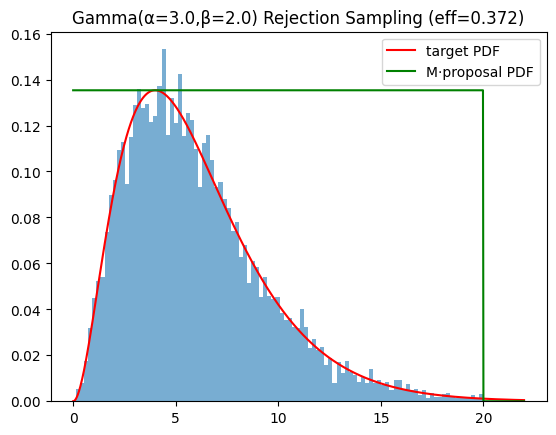

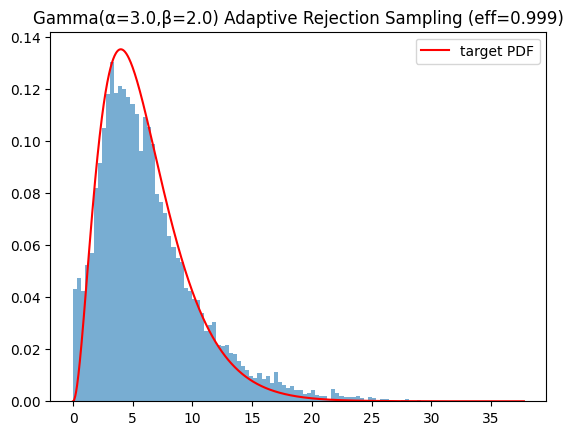

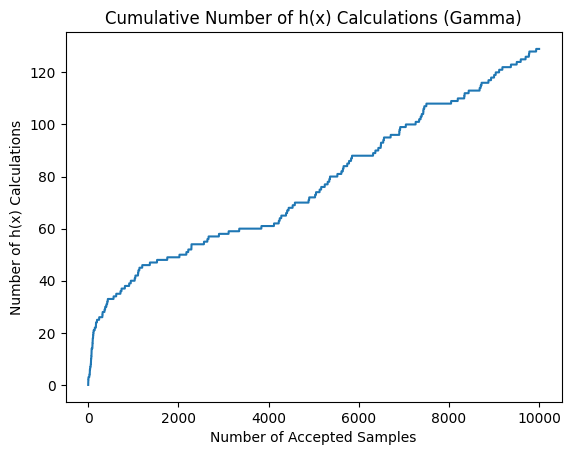

In [286]:
"""
Comparisons between traditional and adaptive rejection sampling using a Gamma(α, β) target distribution
"""

N = 10000

# ----- Gamma target parameters -----
alpha = 3.0
beta = 2.0
mode = (alpha - 1) * beta  # mode of Gamma(α,β)

# Target PDF for Gamma(α, β)
def gamma_pdf(x):
    # support x >= 0
    return np.where(
        x >= 0,
        x**(alpha - 1) * np.exp(-x / beta) / (special.gamma(alpha) * beta**alpha),
        0.0
    )

# ----- Traditional Rejection Sampling -----
rng = RNG()
proposal = Uniform(rng, low=0.0, high=20.0)

# Bounding constant: interval length * maximum of target_pdf on [0,20]
M = 20 * gamma_pdf(mode)

trad_samples, trad_efficiency = rejection_rsv(gamma_pdf, proposal, M, N)

plt.hist(trad_samples, math.floor(math.sqrt(N)), density=True, alpha=0.6)
plt.title(f'Gamma(α={alpha},β={beta}) Rejection Sampling (eff={trad_efficiency:.3f})')

x = np.linspace(0, np.max(trad_samples)*1.1, 1000)
plt.plot(x, gamma_pdf(x), "red",   label="target PDF")
plt.plot(x,   M * proposal.pdf(x), "green", label="M·proposal PDF")
plt.legend()
plt.show()

# ----- Adaptive Rejection Sampling -----
log_pdf  = lambda x: (alpha - 1) * np.log(x) - x / beta \
                     - (math.log(special.gamma(alpha)) + alpha * np.log(beta))
dlog_pdf = lambda x: (alpha - 1) / x - 1 / beta

adap_samples, adap_efficiency, num_calculations, calculations_array = adaptive_rejection_sampling(
    log_pdf, dlog_pdf,
    Dl=0.0, Du=np.inf,
    initial_x=[mode / 2, mode * 2],
    n_samples=N
)

plt.hist(adap_samples, math.floor(math.sqrt(N)), density=True, alpha=0.6)
plt.title(f'Gamma(α={alpha},β={beta}) Adaptive Rejection Sampling (eff={adap_efficiency:.3f})')

x = np.linspace(0, np.max(adap_samples)*1.1, 1000)
plt.plot(x, gamma_pdf(x), "red", label="target PDF")
plt.legend()
plt.show()

plt.plot(calculations_array)
plt.title("Cumulative Number of h(x) Calculations (Gamma)")
plt.xlabel("Number of Accepted Samples")
plt.ylabel("Number of h(x) Calculations")
plt.show()

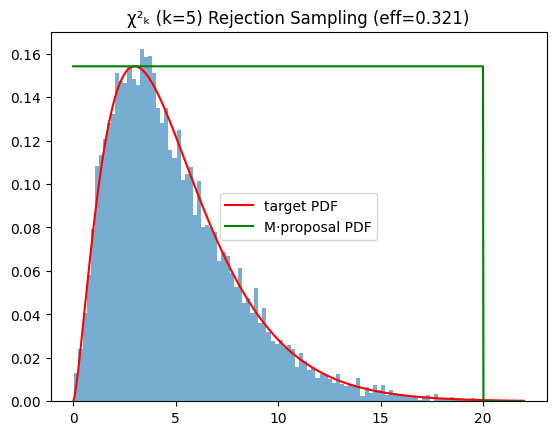

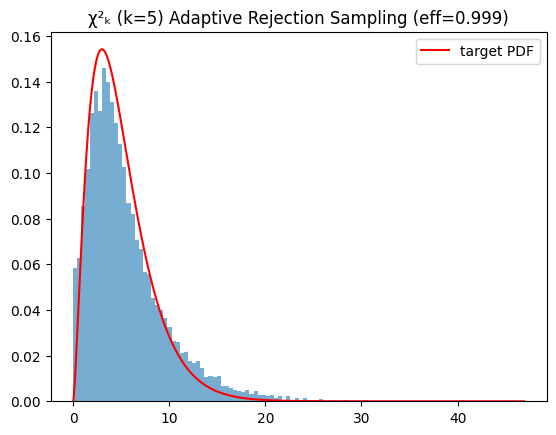

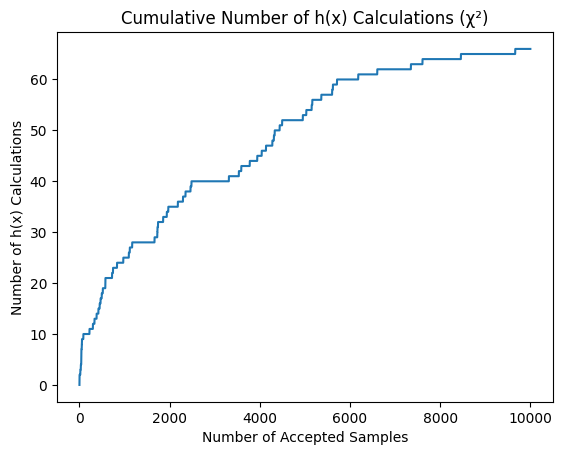

In [287]:
"""
Comparison for Chi‐Square(k) target distribution
"""
N = 10000

# ----- Chi-Square parameters -----
k = 5  # degrees of freedom (must be >2 for a mode)
mode = k - 2

# Target PDF for χ²ₖ
def chi2_pdf(x):
    return np.where(
        x >= 0,
        x**(k/2 - 1) * np.exp(-x/2) / (2**(k/2) * special.gamma(k/2)),
        0.0
    )

# ----- Traditional Rejection Sampling -----
rng = RNG()
proposal = Uniform(rng, low=0.0, high=20.0)

# Pick M = (length of [0,20]) * max target_pdf ≈ 20 * χ²ₖ(mode)
M = 20 * chi2_pdf(mode)

trad_samples, trad_efficiency = rejection_rsv(chi2_pdf, proposal, M, N)

plt.hist(trad_samples, math.floor(math.sqrt(N)), density=True, alpha=0.6)
plt.title(f'χ²ₖ (k={k}) Rejection Sampling (eff={trad_efficiency:.3f})')
x = np.linspace(0, np.max(trad_samples)*1.1, 1000)
plt.plot(x, chi2_pdf(x), 'red',   label='target PDF')
plt.plot(x, M*proposal.pdf(x), 'green', label='M·proposal PDF')
plt.legend()
plt.show()

# ----- Adaptive Rejection Sampling -----
log_pdf  = lambda x: ((k/2 - 1)*np.log(x) - x/2
                     - ((k/2)*np.log(2) + np.log(special.gamma(k/2))))
dlog_pdf = lambda x: (k/2 - 1)/x - 1/2

adap_samples, adap_efficiency, num_calc, calc_array = adaptive_rejection_sampling(
    log_pdf, dlog_pdf,
    Dl=0.0, Du=np.inf,
    initial_x=[mode/2, mode*2],
    n_samples=N
)

plt.hist(adap_samples, math.floor(math.sqrt(N)), density=True, alpha=0.6)
plt.title(f'χ²ₖ (k={k}) Adaptive Rejection Sampling (eff={adap_efficiency:.3f})')
x = np.linspace(0, np.max(adap_samples)*1.1, 1000)
plt.plot(x, chi2_pdf(x), 'red', label='target PDF')
plt.legend()
plt.show()

plt.plot(calc_array)
plt.title("Cumulative Number of h(x) Calculations (χ²)")
plt.xlabel("Number of Accepted Samples")
plt.ylabel("Number of h(x) Calculations")
plt.show()

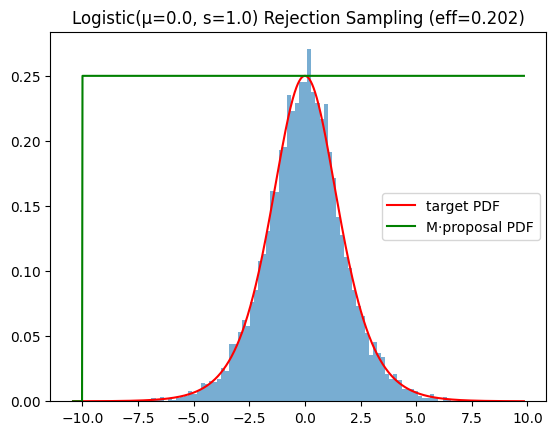

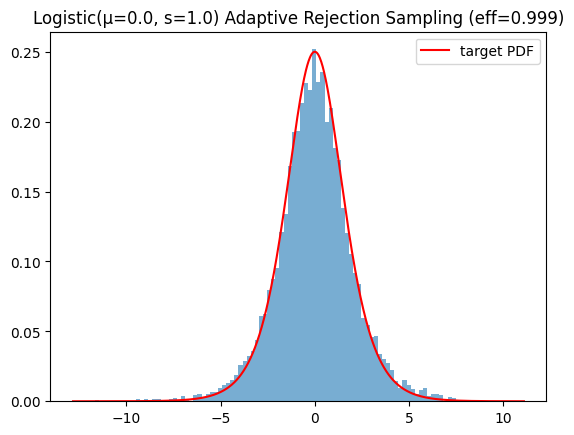

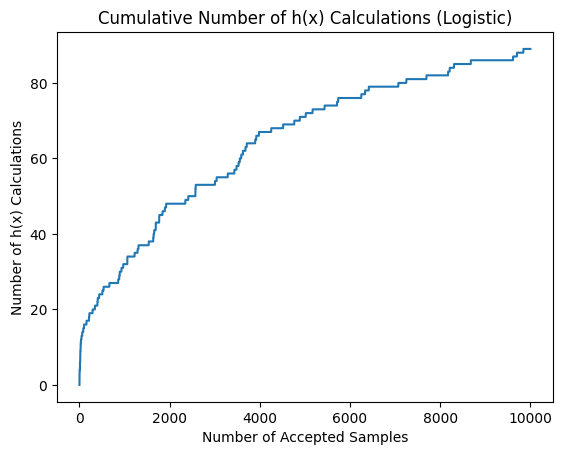

In [288]:
# Comparison for Logistic(μ, s) target distribution
import numpy as np
import math
import matplotlib.pyplot as plt

# ----- Logistic parameters -----
mu = 0.0
s  = 1.0
N  = 10000

# Target PDF for Logistic(μ, s)
def logistic_pdf(x):
    z = (x - mu) / s
    return np.exp(-z) / (s * (1 + np.exp(-z))**2)

# log‑pdf and its derivative
log_pdf  = lambda x: - (x - mu)/s - 2*np.log1p(np.exp(-(x - mu)/s)) - np.log(s)
dlog_pdf = lambda x: -1/s + 2/(s * (1 + np.exp((x - mu)/s)))

# ----- Traditional Rejection Sampling -----
rng      = RNG()
proposal = Uniform(rng, low=mu - 10*s, high=mu + 10*s)
# maximal target/pdf ratio: f(mu)=1/(4s), proposal.pdf=1/(20s) → M = (1/(4s)) / (1/(20s)) = 5
M = 5.0  

trad_samples, trad_efficiency = rejection_rsv(logistic_pdf, proposal, M, N)

plt.hist(trad_samples, math.floor(math.sqrt(N)), density=True, alpha=0.6)
plt.title(f'Logistic(μ={mu}, s={s}) Rejection Sampling (eff={trad_efficiency:.3f})')
x = np.linspace(np.min(trad_samples)*1.1, np.max(trad_samples)*1.1, 1000)
plt.plot(x, logistic_pdf(x), 'red',   label='target PDF')
plt.plot(x,   M * proposal.pdf(x), 'green', label='M·proposal PDF')
plt.legend()
plt.show()


# ----- Adaptive Rejection Sampling -----
adap_samples, adap_efficiency, num_calc, calc_array = adaptive_rejection_sampling(
    log_pdf, dlog_pdf,
    Dl=-np.inf, Du=np.inf,
    initial_x=[mu - 2*s, mu + 2*s],
    n_samples=N
)

plt.hist(adap_samples, math.floor(math.sqrt(N)), density=True, alpha=0.6)
plt.title(f'Logistic(μ={mu}, s={s}) Adaptive Rejection Sampling (eff={adap_efficiency:.3f})')
x = np.linspace(np.min(adap_samples)*1.1, np.max(adap_samples)*1.1, 1000)
plt.plot(x, logistic_pdf(x), 'red', label='target PDF')
plt.legend()
plt.show()

plt.plot(calc_array)
plt.title("Cumulative Number of h(x) Calculations (Logistic)")
plt.xlabel("Number of Accepted Samples")
plt.ylabel("Number of h(x) Calculations")
plt.show()